---
title: "Demystifying AdaBoost"
description: "Building the AdaBoost Algorithm from Scratch in Python"
date: 2024-09-19
image: adaboost.png
categories: [boosting, machine-learning, ada-boosting, sklearn]
---

### Table of Contents
1. [Introduction](#introduction)
2. [AdaBoost Algorithm](#adaboost)
3. [AdaBoost Implementation](#adaboost-implementation)
4. [Conclusion](#conclusion)
5. [References](#references)

### Introduction {#introduction}

#### Ensemble Methods

An ensemble method constructs **set of classifiers**, and then classifies new data points by taking weighted vote of their predictions. It combine decisions from multiple models to improve performance, rather than a single model.

There are basically 2 Methods of implementing ensemble methods that are popular in machine learning.
  - Random Forests
  - Gradient Boosted Trees

#### Boosting:
- This is the type of algorithm where weak learners added sequentially
- Here, weak learners are trained on previous weak models.
- Final model is obtained by **additive modeling** of the weak learner models.

  $$
	F(x) = \sum_{t=1}^{M} \alpha_t h_t(x) 
	$$

In this blog, we'll pull back the curtain on **Adaptive Boosting (AdaBoost)** by implementing it from scratch. 

In [1]:
import sklearn
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

We generate random moon data, with 10000 number of samples.

In [2]:
# generating random data
dataset = make_moons(n_samples=10000,
                     shuffle=True,
                     #   n_classes=3,
                     random_state=82,
                     noise=0.3
                     )
print(type(dataset))

<class 'tuple'>


In [3]:
dataset[0].shape, dataset[1][:5], type(dataset[1]), set(dataset[1])

((10000, 2), array([1, 1, 0, 0, 0]), numpy.ndarray, {np.int64(0), np.int64(1)})

In [4]:
X, y = dataset
X.shape, y.shape

((10000, 2), (10000,))

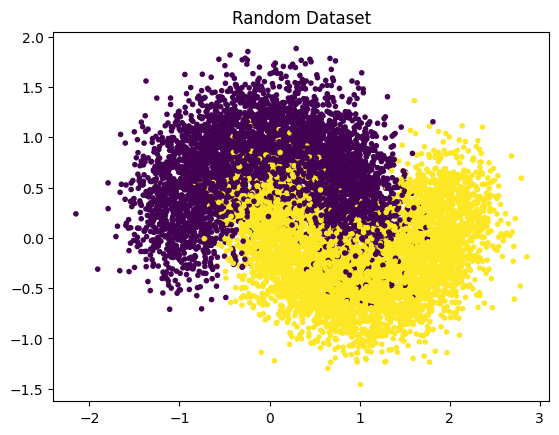

In [5]:
plt.title("Random Dataset")
plt.scatter(X[:, 0], X[:, 1], marker='.',c=y)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=82)
print(f'X_train:{X_train.shape}, X_test:{X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}')

X_train:(7000, 2), X_test:(3000, 2), y_train:(7000,), y_test:(3000,)


### AdaBoost Algorithm {#adaboost}

The AdaBoost algorithm follows these key steps:

1. Initialize Weights: Start by giving every data point an equal weight.

2. Iterate: For a set number of iterations (estimators): 
	- Train a Weak Learner: Train a simple model on the data, using the current weights. Points with higher weights will have more influence on the model's training.
	- Calculate Weighted Error: Determine how many of the heavily-weighted points the model got wrong.
	- Calculate $\alpha$: Assign a weight $(\alpha)$ to the trained model. Models with lower error get a higher alpha, meaning they have more say in the final prediction.
	- Update Weights: Increase the weights of the points the model misclassified. This is the 'adaptive' part; making the tough examples more important for the next iteration.
	- Normalize Weights: Ensure all weights sum to 1.

3. Final Prediction: To classify a new point, get the prediction from all weak learners and combine them using a **weighted vote**, where the weights are the alpha values.

### AdaBoost Implementation in Python{#adaboost-implementation}

In [11]:
class AdaBoost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # initial equal weights
        weights = np.ones(n_samples)/n_samples
        weights[np.isnan(weights)] = 0
        # weights = np.array([0.0000000001 if i==0  else i for i in weights])
        for i in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)

            model.fit(X, y, sample_weight=weights)
            y_pred = model.predict(X)
            # print(y_pred,y)
            
			# calculate weighted error
            error = np.sum(weights*(y_pred!=y))/np.sum(weights)
            print(f"Error for {i} model is {error:.3f}")

            # added 1e-10 so as to not get NaN values in the weights
            alpha = 0.5*np.log((1-error)/(error + 1e-10))
            self.alphas.append(alpha)
            self.models.append(model)

            weights *= np.exp(-alpha*y*y_pred)
            weights /= np.sum(weights)

        print(f'\nAlphas modified into: {self.alphas}')

	# tally the weighted votes from all our trained models.
    def predict(self, X,  y):
        n_samples, _ = X.shape

        predictions = np.zeros(n_samples)
        for alpha, model in zip(self.alphas, self.models):
            print(f'Accuracy for single model: {accuracy_score(model.predict(X), y)}')
            predictions += alpha*model.predict(X)

        return np.sign(predictions)

Here, we initialize the model to the class we just created.

In [12]:
model = AdaBoost()
model

In [13]:
model.fit(X_train, y_train)

Error for 0 model is 0.196
Error for 1 model is 0.219
Error for 2 model is 0.187
Error for 3 model is 0.252
Error for 4 model is 0.252
Error for 5 model is 0.252
Error for 6 model is 0.252
Error for 7 model is 0.252
Error for 8 model is 0.252
Error for 9 model is 0.252

Alphas modified into: [np.float64(0.7057423047191226), np.float64(0.6367577620190208), np.float64(0.7341725283661305), np.float64(0.542923918364508), np.float64(0.542923918364508), np.float64(0.542923918364508), np.float64(0.542923918364508), np.float64(0.542923918364508), np.float64(0.542923918364508), np.float64(0.542923918364508)]


In [14]:
accuracy_score(model.predict(X_test, y_test),  y_test)

Accuracy for single model: 0.8023333333333333
Accuracy for single model: 0.7896666666666666
Accuracy for single model: 0.6666666666666666
Accuracy for single model: 0.49433333333333335
Accuracy for single model: 0.49433333333333335
Accuracy for single model: 0.49433333333333335
Accuracy for single model: 0.49433333333333335
Accuracy for single model: 0.49433333333333335
Accuracy for single model: 0.49433333333333335
Accuracy for single model: 0.49433333333333335


0.8463333333333334

### Conclusion{#conclusion}
Here, we can see the individual accuracy of model are around `50` and just 3 models have 66, 78 and  80% accuracy. However, with AdaBoosting, the learned weights are assigned get the final accuracy of **84%**.

### References{#references}

- [OSU paper (PDF)](https://web.engr.oregonstate.edu/~tgd/publications/mcs-ensembles.pdf)  
- [scikit-learn: Ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)  
- [ML from Scratch: AdaBoost code](https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/supervised_learning/adaboost.py)  
- [sklearn.datasets.make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons)
